# Machine Learning Potentials

Machine Learning Interatomic Potentials (MLIPs) are an increasingly popular method of simulating molecular systems.  In both speed and accuracy, they are intermediate between classical force fields on one hand and high level quantum chemistry methods on the other.  The [OpenMM-ML](https://github.com/openmm/openmm-ml) package provides a simple, easy to use interface for using them in OpenMM.

MLIPs cover a large class of models.  They begin with some type of machine learning model, typically a neural network, often supplemented with standard physics based interactions.  The parameters of the model are trained to reproduce a large library of forces and energies, which are typically generated with a highly accurate quantum chemistry method.  The resulting model can approach the accuracy of the original method while being many times faster.  Some MLIPs are specific to just one molecule, while others are trained to cover large areas of chemical space and be applicable to arbitrary systems with no further training.  The latter are often known as "foundation models".  OpenMM-ML supports both types of models.  This tutorial focuses on foundation models, which are much easier to use and more widely useful.  Specialized models usually require you to train your own model for whatever system you want to simulate, a much larger task than just selecting a pre-trained, ready to use model.  The tradeoff is that a specialized model for one specific molecule can be much smaller and faster than a general purpose model of similar accuracy.

While the details vary, a good rule of thumb is that MLIPs are about 1000 times slower than classical force fields, but about 1000 times faster than high level quantum chemistry methods.  That might change in the future, but they are unlikely to replace force fields any time soon.  They are mostly useful for relatively small systems, or small pieces of larger systems.  When used in that way, they enable simulations that would be impossibly slow with conventional quantum mechanical methods.

## Installing Models

OpenMM-ML provides a common interface for working with many different models, but it does not provide the models itself.  They must be installed separately using whatever method the model developer has chosen.  Unfortunately, the ecosystem of MLIPs is still very immature and inconsistent.  Some models are installed with `pip`, some with `conda`, and some must be downloaded directly from the developer's website.  Some require you to install a Python package, and also to download a file containing model parameters from a different source.  The packages implementing MLIPs tend to depend on many other packages, and often they require specific versions of those packages that make them incompatible with each other.

Perhaps this situation will improve with time.  For now, it is best to create a separate Python environment for ML simulations, or possibly multiple environments for different MLIPs you want to use.

For this tutorial, we will use the [AIMNet2](https://github.com/isayevlab/aimnetcentral) potential.  The following commands create an environment that can run simulations with this potential.  We also install MDAnalysis, which is not needed to run simulations but is used in this tutorial for analyzing results.

```
conda create --name aimnet2 python=3.12
conda activate aimnet2
pip install git+https://github.com/isayevlab/aimnetcentral.git
pip install openmmtorch[cuda12] openmmml mdanalysis
```

## Running ML Simulations

With that out of the way, let's try simulating something.  First we import libraries that will be used during the simulation.

In [1]:
from openmm import *
from openmm.app import *
from openmm.unit import *
from openmmml import MLPotential
import MDAnalysis as mda
from MDAnalysis.analysis.dihedrals import Ramachandran
import sys
import logging

logging.basicConfig(level=logging.ERROR)

As an example, let's simulate alanine dipeptide in vacuum.  We can load the model from a PDB file.

In [2]:
pdb = PDBFile('alanine-dipeptide.pdb')
print(pdb.topology)

<Topology; 1 chains, 3 residues, 22 atoms, 21 bonds>


Now create a System for it.

In [3]:
potential = MLPotential('aimnet2')
system = potential.createSystem(pdb.topology)

That's all there is to it!  MLPotential plays the same role in ML simulations that ForceField does in conventional simulations.  You create an instance of it, specifying the name of the potential to use, then call `createSystem()` to create a System to simulate.

To prove we really have a working System, let's run a short simulation.

In [4]:
integrator = LangevinIntegrator(300*kelvin, 1.0/picosecond, 0.001*picoseconds)
simulation = Simulation(pdb.topology, system, integrator)
simulation.reporters.append(StateDataReporter(sys.stdout, 100, potentialEnergy=True, temperature=True, step=True, speed=True))
simulation.context.setPositions(pdb.positions)
simulation.step(1000)

#"Step","Potential Energy (kJ/mole)","Temperature (K)","Speed (ns/day)"
100,-1302747.83036788,55.835824168728706,0
200,-1302746.1318177246,94.37135932017648,11.8
300,-1302732.5579721972,123.49092099269907,11.9
400,-1302726.5844298073,149.443899780796,11.9
500,-1302715.6813423317,158.42731341763903,11.9
600,-1302720.6863631993,163.37858024843084,11.7
700,-1302712.047612447,160.39312972689297,11.7
800,-1302719.6467883936,212.2647280843627,11.8
900,-1302710.7203451698,155.41720407571125,11.8
1000,-1302714.462791466,188.5679366883866,11.8


Only about 11 ns/day for a molecule with 22 atoms.  (That simulation was run on an NVIDIA RTX 4080 GPU.)  I warned you that MLIPs were slow!  On the other hand, we simulated 1000 steps in only a few seconds.  Most quantum chemistry methods with similar accuracy would take that long to perform a single energy evaluation.

Let's try something a bit more interesting: run a longer simulation and compute a Ramachandran plot.

In [5]:
def simulate(system):
    # Prepare a Simulation

    integrator = LangevinIntegrator(300*kelvin, 1.0/picosecond, 0.001*picoseconds)
    simulation = Simulation(pdb.topology, system, integrator)
    simulation.context.setPositions(pdb.positions)
    simulation.context.setVelocitiesToTemperature(300*kelvin)

    # Equilibrate

    simulation.step(1000)

    # Generate data

    simulation.reporters.append(XTCReporter('alanine-dipeptide.xtc', 100))
    simulation.step(100000)

Let's see how long it takes.

In [6]:
%%time
simulate(system)

CPU times: user 12min 35s, sys: 2.39 s, total: 12min 37s
Wall time: 12min 39s


We can use [MDAnalysis](https://www.mdanalysis.org/) to do the analysis and generate the plot.

<Axes: xlabel='$\\phi$', ylabel='$\\psi$'>

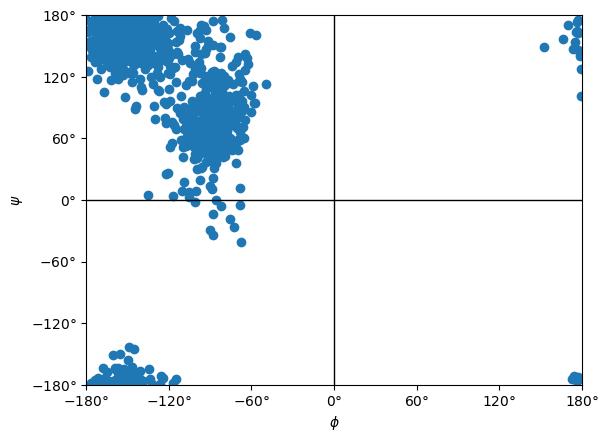

In [7]:
u = mda.Universe('alanine-dipeptide.pdb', 'alanine-dipeptide.xtc')
ramachandran = Ramachandran(u.select_atoms("protein")).run()
ramachandran.plot()

## Simulating Mixed ML/MM Systems

The behavior of alanine dipeptide (and most other organic molecules) is very different in vacuum from in water.  We would prefer to simulate it in a box of water, but that requires many times more atoms.  Simulating it entirely with an MLIP would be very, very slow.

Instead we can use a mixed system.  We will use AIMNet2 only to compute the internal energy of the alanine dipeptide molecule.  The internal energy of the water, and the interaction energy between the water and solute, will be computed with a classical force field.

First we load a PDB file with the solvated alanine dipeptide.

In [9]:
pdb = PDBFile('alanine-dipeptide-water.pdb')
print(pdb.topology)

<Topology; 750 chains, 752 residues, 2269 atoms, 1519 bonds>


To create a mixed system, we first create an ordinary System that models everything with a conventional force field. 

In [10]:
ff = ForceField('amber19-all.xml', 'amber19/tip3pfb.xml')
mm_system = ff.createSystem(pdb.topology, nonbondedMethod=PME)

Now we use our MLPotential to create a new System that replaces a subset of interactions with the MLIP.  We simply give it the conventional System, and a list of atom indices to model with ML.

In [11]:
chains = list(pdb.topology.chains())
ml_atoms = [atom.index for atom in chains[0].atoms()]
ml_system = potential.createMixedSystem(pdb.topology, mm_system, ml_atoms)

Let's simulate the mixed System and see how the speed compares to the other simulation.

In [12]:
%%time
simulate(ml_system)

CPU times: user 12min 35s, sys: 1.51 s, total: 12min 37s
Wall time: 12min 41s


This simulation includes 100 times more atoms than the previous one, but took no longer to run!  The classical force field is so much faster than the MLIP, it adds very little to the total time.

The Ramachandran plot looks quite different from before, showing the importance of water.

<Axes: xlabel='$\\phi$', ylabel='$\\psi$'>

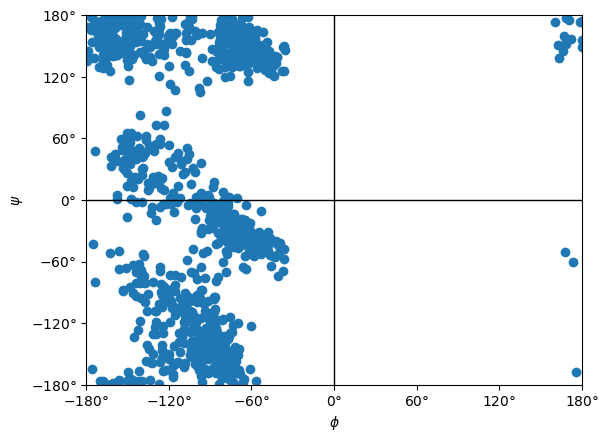

In [13]:
u = mda.Universe('alanine-dipeptide-water.pdb', 'alanine-dipeptide.xtc')
ramachandran = Ramachandran(u.select_atoms("protein")).run()
ramachandran.plot()

## Going Further

OpenMM-ML supports lots of other MLIPs.  That includes pretrained foundation models, as well as models you train yourself with popular frameworks such as [MACE](https://github.com/ACEsuit/mace) and [NequIP](https://github.com/mir-group/nequip).

Particular models may have additional options you can specify to control their behavior.  For example, AIMNet2 lets you specify the charge and spin multiplicity of the system to simulate.  This allows you to use it for simulating charged molecules:

```
system = potential.createSystem(pdb.topology, charge=1)
```

See [the documentation](https://openmm.github.io/openmm-ml/latest/index.html) for details on how to use these features.